# Interpretable forecasting with N-Beats

In [1]:
import os
import warnings

warnings.filterwarnings("ignore")

os.chdir("../../..")

In [2]:
import pandas as pd
import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping

from pytorch_forecasting import TimeSeriesDataSet, NBeats, Baseline
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.data.examples import generate_ar_data
from pytorch_forecasting.metrics import SMAPE

## Load data

We generate a synthetic dataset to demonstrate the network's capabilities. The data consists of a quadratic trend and a seasonality component.

In [3]:
data = generate_ar_data(seasonality=10.0, timesteps=400, n_series=100, seed=42)
data["static"] = 2
data["date"] = pd.Timestamp("2020-01-01") + pd.to_timedelta(data.time_idx, "D")
data.head()

,series,time_idx,value,static,date
0,0,0,-0.000000,2,2020-01-01
1,0,1,-0.046501,2,2020-01-02
2,0,2,-0.097796,2,2020-01-03
3,0,3,-0.144397,2,2020-01-04
4,0,4,-0.177954,2,2020-01-05


Before starting training, we need to split the dataset into a training and validation TimeSeriesDataSet.

In [4]:
# create dataset and dataloaders
max_encoder_length = 60
max_prediction_length = 20

training_cutoff = data["time_idx"].max() - max_prediction_length

context_length = max_encoder_length
prediction_length = max_prediction_length

training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="value",
    categorical_encoders={"series": NaNLabelEncoder().fit(data.series)},
    group_ids=["series"],
    # only unknown variable is "value" - and N-Beats can also not take any additional variables
    time_varying_unknown_reals=["value"],
    max_encoder_length=context_length,
    max_prediction_length=prediction_length,
)

validation = TimeSeriesDataSet.from_dataset(training, data, min_prediction_idx=training_cutoff+1)
batch_size = 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

## Calculate baseline error

Our baseline model predicts future values by repeating the last know value. The resulting sMAPE is disappointing and should not be easy to beat.

In [5]:
# calculate baseline absolute error
actuals = torch.cat([y for x, y in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
SMAPE()(baseline_predictions, actuals)

tensor(0.5462)

## Train network 

Finding the optimal learning rate using PyTorch Lightning is easy. The key hyperparameter are the widths. Each denotes the width of each forecasting block. By default, the first forecasts the trend, while the second forecasts seasonality.

In [6]:
pl.seed_everything(42)
trainer = pl.Trainer(gpus=0, gradient_clip_val=0.1)
net = NBeats.from_dataset(training, learning_rate=3e-2, weight_decay=1e-2, widths=[32, 512])

GPU available: False, used: False
TPU available: False, using: 0 TPU cores



  | Name       | Type       | Params
------------------------------------------
0 | loss       | SMAPE      | 0     
1 | net_blocks | ModuleList | 1 M   


Saving latest checkpoint..
LR finder stopped early due to diverging loss.


suggested learning rate: 0.003890451449942806


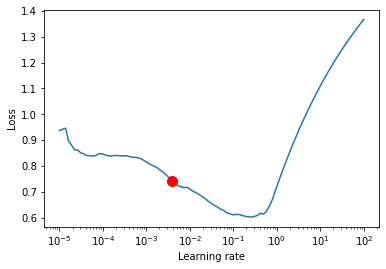

In [7]:
# find optimal learning rate
res = trainer.tuner.lr_find(net, train_dataloader=train_dataloader, val_dataloaders=val_dataloader, min_lr=1e-5, max_lr=1e2)
print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()
net.hparams.learning_rate = res.suggestion()

Fit model

In [8]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
trainer = pl.Trainer(
    max_epochs=100,
    gpus=0,
    weights_summary="top",
    gradient_clip_val=0.1,
    early_stop_callback=early_stop_callback,
    limit_train_batches=30,
)


net = NBeats.from_dataset(training, learning_rate=4e-3, log_interval=10, log_val_interval=1, weight_decay=1e-2, widths=[32, 512])

trainer.fit(
    net, train_dataloader=train_dataloader, val_dataloaders=val_dataloader,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name       | Type       | Params
------------------------------------------
0 | loss       | SMAPE      | 0     
1 | net_blocks | ModuleList | 1 M   


Saving latest checkpoint..


1

### Evaluate Results

In [9]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = NBeats.load_from_checkpoint(best_model_path)

We calculate the error which is well below the baseline error

In [10]:
actuals = torch.cat([y for x, y in iter(val_dataloader)])
predictions = best_model.predict(val_dataloader)
(actuals - predictions).abs().mean()

tensor(0.1826)

Looking at random samples from the validation set is always a good way to understand if the forecast is reasonable - and it is!

In [11]:
raw_predictions, x = best_model.predict(val_dataloader, mode="raw", return_x=True)

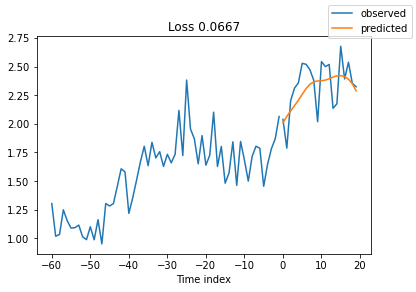

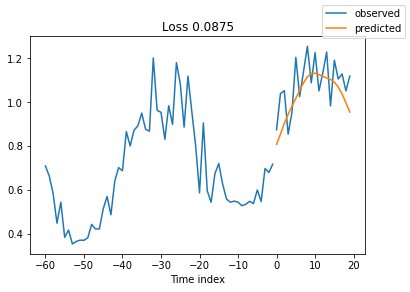

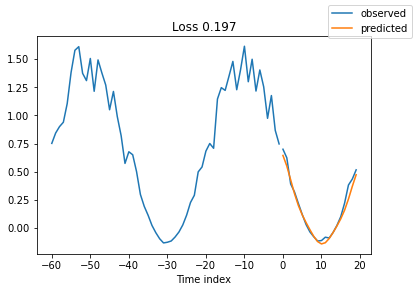

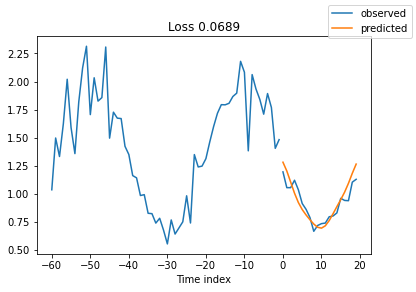

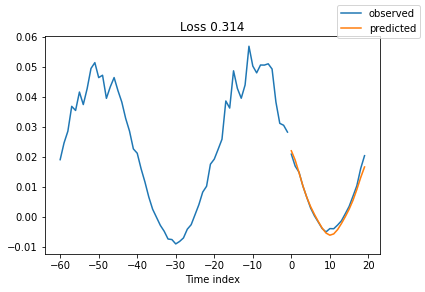

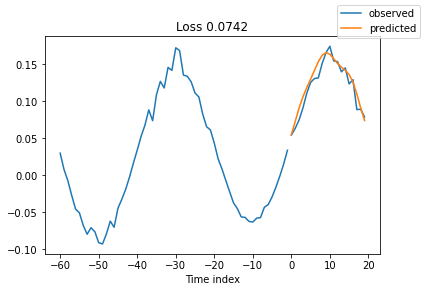

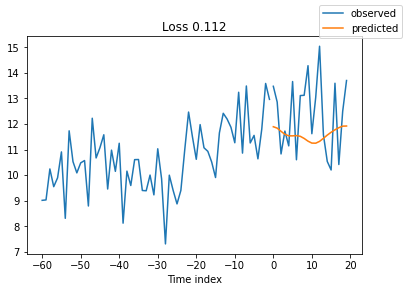

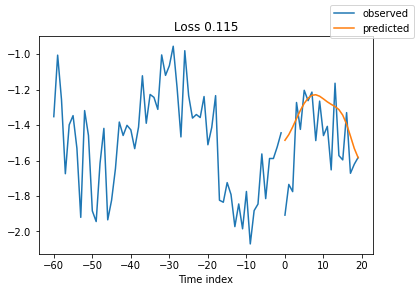

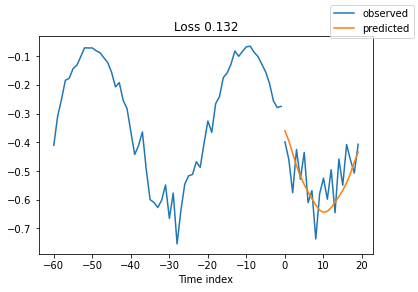

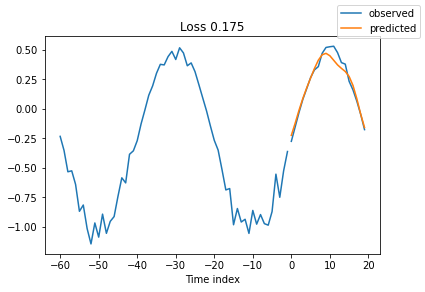

In [12]:
for idx in range(10):  # plot 10 examples
    best_model.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);

## Interpret model

We can ask PyTorch Forecasting to decompose the prediction into seasonality and trend. The results show that there seem to be many ways to explain the data and the algorithm does not always chooses the one making intuitive sense. This is partially down to the small number of time series we trained on (100). But it is also due because our forecasting period does not cover multiple seasonalities.

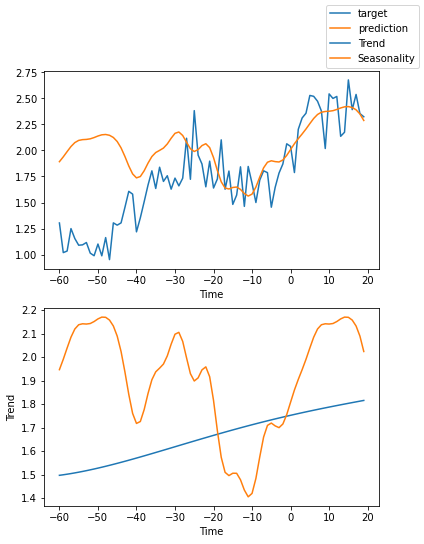

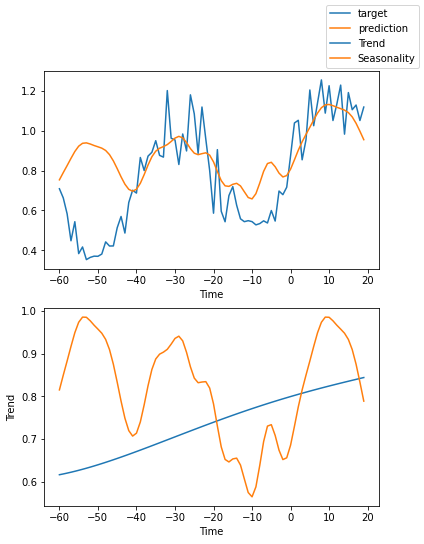

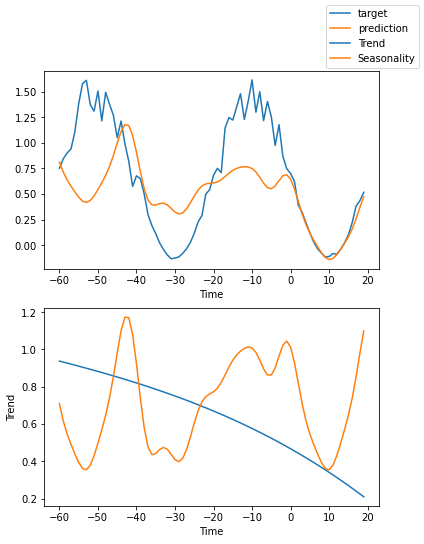

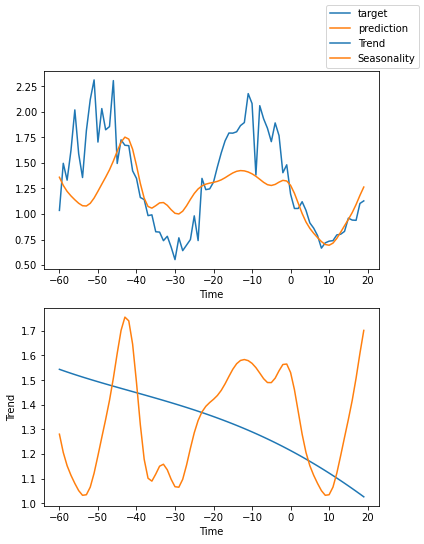

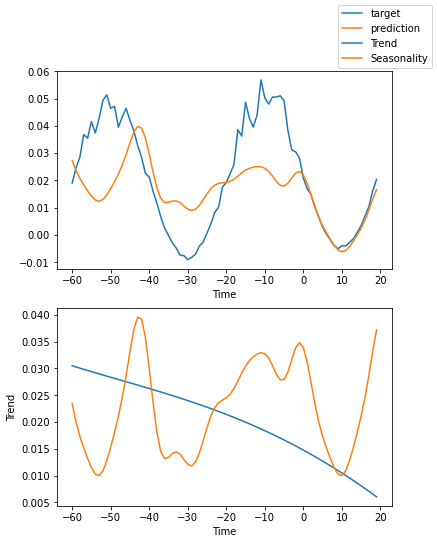

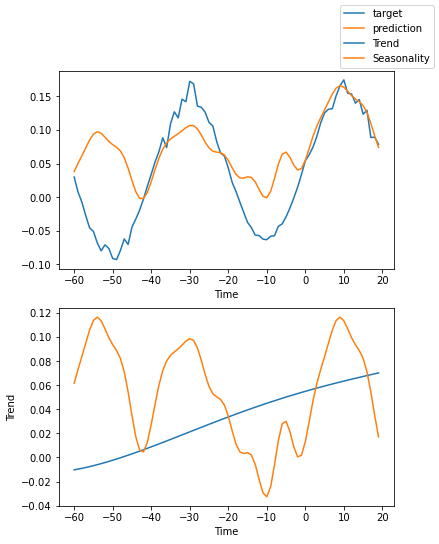

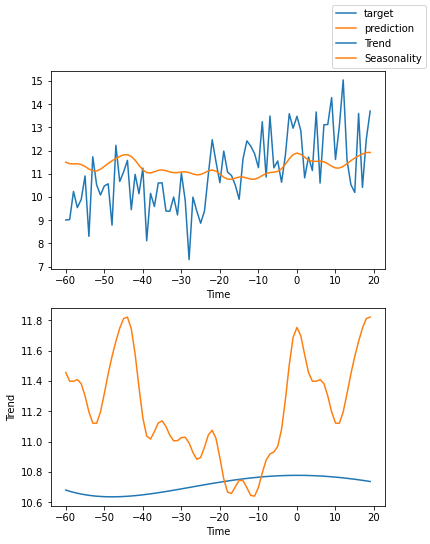

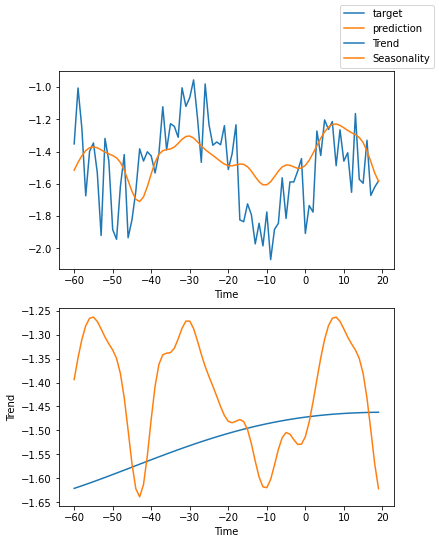

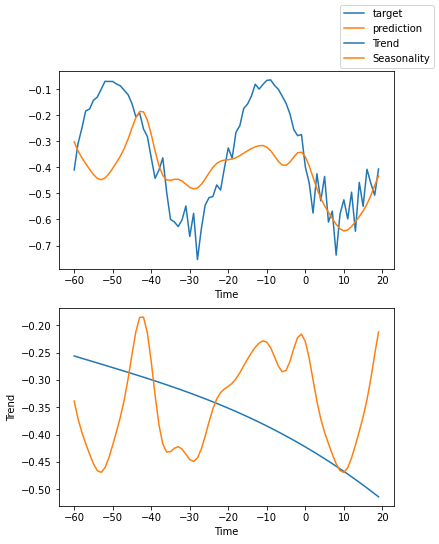

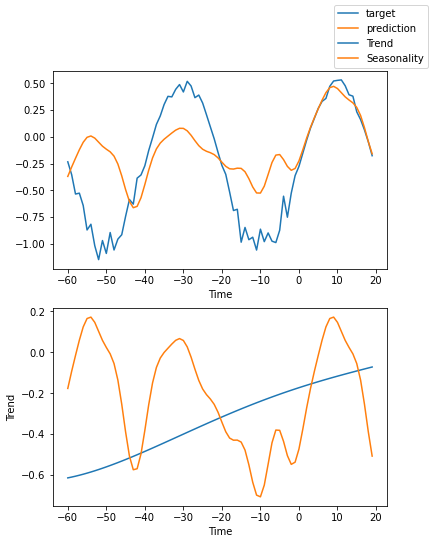

In [13]:
for idx in range(10):  # plot 10 examples
    best_model.plot_interpretation(x, raw_predictions, idx=idx);